# Million-scale Dialogue Distillation with Social Commonsense Contextualization

https://arxiv.org/pdf/2212.10465.pdf

SODA는 공개적으로 사용가능한 million-scale high-quality social dialogue dataset  

연구진은 SODA를 이용하여 conversation model(COSMO)를 학습 다른 모델보다 좋은 성능(자연스럽고 좀더 사람같은)을 보임


대화 모델은 training corpora의 diversity, scale, quality의 부족으로 인해 원하는 성능을 내기 어려웠음   
대부분은 대량의 unfiltered conversations를 이용하나 여러 문제를 겪음.  
더 자연스런 지문을 얻고자 PLMs 를 이용하여 dataset을 생성(SOcial DiAlogues)

PLM(Pre-trained Language Model)을 이용함으로써 두가지 장점을 얻음  
1. minimizing nonsensical conversation
2. maximizing diversity

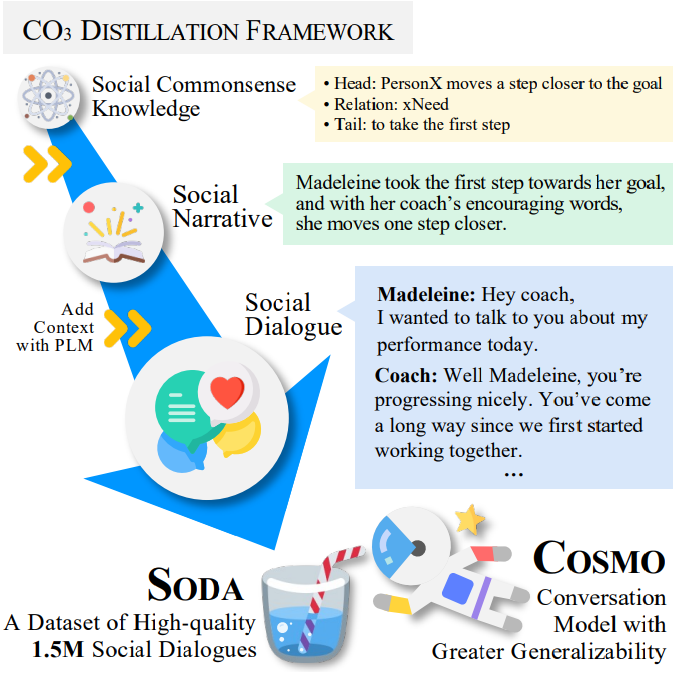

## $CO_3$ : Contextualizing Commensense for Conversations step-by-step

**Commonsense knowledge graph**  
>knowledge graph는 event의 묘사를 하는 head, tail 
그 사이 관계를 나타내는 relation  
Atomic을 사용  
>- Head : PersonX goes to an amusement park  
>- Relation : xIntent  
>- Tail : have fun riding attractions  

**From commonsense knowledge to narrative**  
>Triple form to sentence form
>  - graph 형식을 하나의 문장으로 변형
>  - [triple form] → David goes to an amusement park to have fun riding attractions  
>
>sentence form to narrative
>  - 두 세 문장의 짧은 narrative로 변환, PLM을 이용하여 쉽게 디테일을 생성할 수 있음
>  - David goes to an amusement park and has a blast riding the bumper cars, the Ferris wheel, and the roller coaster. He loves feeling the wind in his hair and screaming at the top of his lungs.

**From Narrative to Conversation inferring speakers from the narrative**  
>이미 이야기에서 person에 관한 변수가 있어서 쉽게 추론할수 있고 만약 등장인물이 한명이더라도 PLM을 이용하여 대화상대를 예측하여 등장인물 설정
>
> - [narrative] The following is a conversation in the scene between [PersonX’s name] and ...

**Generating conversations grounded in narratives**

>narrative, speakers를 input으로 하여 대화 생성  
>narrative는 context의 역할을, speakers는 장면의 등장인물이 됌  
>
> - [narrative] The following is a long in-depth conversation happening in the
scene between David and his friend Sarah
with multiple turns.\nDavid:


**Validating narratives and conversations with commonsense knowledge**

>seed commonsense triple이 narrative+conversation에 잘 들어있는지 확인하는 작업  
> - [narrative]\nQ: [head question]\nA:  
> - [conversation]\nQ: [relation-tail question]\nA:  






이후에 약간의 필터링을 걸쳐 총 1,486,896 개의 대화를 생성

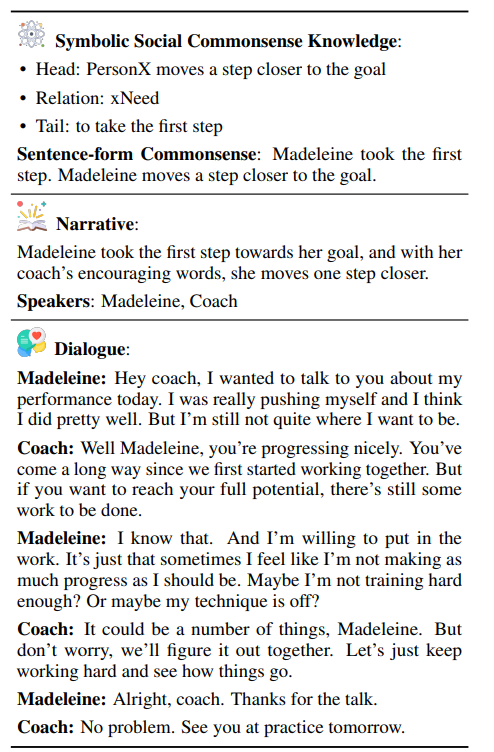

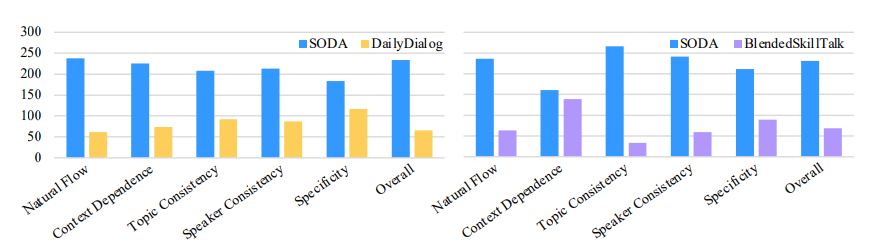

여러 방면에서 좋은 평가를 얻음

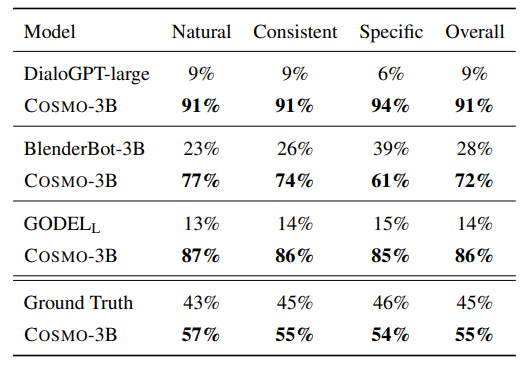

각 모델들은 DailyDialog 를 제외하고 다른 set으로 학습 후 DailyDialog에 대한 답변을 비교한 것

In [2]:
!pip install transformers
!pip install sentencepiece
!pip install colorful

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 100.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 KB 6.0 MB/s eta 0:00:00


In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import colorful as cf
cf.use_true_colors()
cf.use_style('monokai')


class CosmoAgent:
    def __init__(self):
        print(cf.bold | cf.purple("Loading COSMO-xl..."))
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained("allenai/cosmo-xl")
        self.model = AutoModelForSeq2SeqLM.from_pretrained("allenai/cosmo-xl").to(self.device)
        self.conversation_history = []

    def observe(self, observation):
        self.conversation_history.append(observation)

    def set_input(self, situation_narrative="", role_instruction=""):
        input_text = " <turn> ".join(self.conversation_history)

        if role_instruction != "":
            input_text = "{} <sep> {}".format(role_instruction, input_text)

        if situation_narrative != "":
            input_text = "{} <sep> {}".format(situation_narrative, input_text)

        return input_text

    def generate(self, situation_narrative, role_instruction, user_response):

        self.observe(user_response)

        input_text = self.set_input(situation_narrative, role_instruction)

        inputs = self.tokenizer([input_text], return_tensors="pt").to(self.device)
        outputs = self.model.generate(inputs["input_ids"], max_new_tokens=100, temperature=1.0, top_p=.95, do_sample=True)
        cosmo_response = self.tokenizer.decode(outputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)

        self.observe(cosmo_response)

        return cosmo_response

    def reset_history(self):
        self.conversation_history = []

    def run(self):
        def get_valid_input(prompt, default):
            while True:
                user_input = input(prompt)
                if user_input in ["Y", "N", "y", "n"]:
                    return user_input
                if user_input == "":
                    return default
        
        while True:
            continue_chat = ""
            situation_narrative = input(cf.yellow("Input the situation description/narrative of the conversation (You can leave it empty):"))
            if situation_narrative == "":
                situation_narrative = "Cosmo is having a friendly conversation with a friend."
            role_instruction = input(cf.orange("Which role should Cosmo take? Who is Cosmo talking to? (You can leave it empty):"))
            if role_instruction == "":
                role_instruction = "You are Cosmo and you are talking to a friend."

            self.chat(situation_narrative, role_instruction)
            continue_chat = get_valid_input(cf.purple("Start a new conversation with new setup? [Y/N]:"), "Y")
            if continue_chat in ["N", "n"]:
                break

        print(cf.blue("Cosmo: See you!"))

    def chat(self, situation_narrative, role_instruction):
        print(cf.green("Chat with Cosmo! Input [RESET] to reset the conversation history and [END] to end the conversation."))
        while True:
            user_input = input("You: ")
            if user_input == "[RESET]":
                self.reset_history()
                print(cf.green("[Conversation history cleared. Chat with Cosmo!]"))
                continue
            if user_input == "[END]":
                break
            response = self.generate(situation_narrative, role_instruction, user_input)
            print(cf.blue("Cosmo: " + response))

def main():
    print(cf.bold | cf.blue("Welcome to SODAverse!"))
    cosmo = CosmoAgent()
    cosmo.run()

In [6]:
main()

Welcome to SODAverse!
Loading COSMO-xl...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Chat with Cosmo! Input [RESET] to reset the conversation history and [END] to end the conversation.
Cosmo: What do you want? I don't have anything worth taking.
Cosmo: No way! I'm not going to let you eat me!
Cosmo: Please, don't eat me! I have a family!
Cosmo: No, please, I won't let you hurt them!
Cosmo: My face is like a human's. Except it's red.
Cosmo: My eyes are red and have green eyes. My skin is black and white. And my nose is red and pointy.
Cosmo: That doesn't help much! How about the rest of me?
Cosmo: No! Please, just let me go!
Cosmo: Please!
Cosmo: What do you want from me?
Cosmo: No! Get off me! Help!
Cosmo: Yes, I can! Just don't eat my arm!


KeyboardInterrupt: ignored